In [41]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

Pseudo-code
GOAL: take in RAW, not quality controlled data and clean it up. This does NOT include interpolation of missing data points, but does include:
1. Compare to sensor health data or logs of known failure periods and remove data in those windows
2. Plausible value check. Removes any values that are beyond standard range for each variable
3. Remove noise. Higher-level processing but could follow USGS methods
4. Compare site-best. If multiple sensors exist for a given data variable, compare values and fill gaps 
5. Combine data files. If data is separated into multiple datafiles, resample to get on the same time basis (can resample to hourly here, or the lowest resolution of what is available). Combine files with consistent naming into one dataframe for checks

In [42]:
AWS_fp = '~/research/climate_data/AWS/Raw/'
data_fns = ['SouthGlacier_AWS_HalfHourData.csv','SouthGlacier_AWS_FiveMinData.csv','SouthGlacier_AWS_HealthData.csv']
time_vn = 'TIMESTAMP'
force_dates = ['2008-05-01 00:00','2008-09-14 00:00']

In [43]:
df = pd.read_csv(AWS_fp+data_fns[0])
start = pd.to_datetime(df[time_vn][0])
end = pd.to_datetime(df[time_vn][np.shape(df)[0]-1])
df = df.set_index(pd.to_datetime(df[time_vn]))
if force_dates is not None:
    df = df.loc[force_dates[0]:force_dates[1]]
df.columns

Index(['TIMESTAMP', 'RECORD', 'DT', 'TCDT', 'BP', 'BPSC', 'Rain_mm_Tot'], dtype='object')

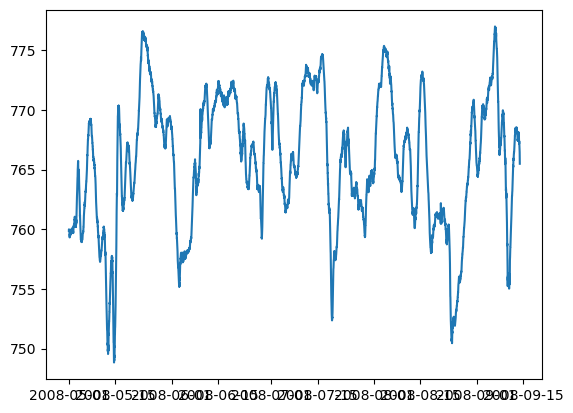

In [44]:
import matplotlib.pyplot as plt
plt.plot(df.index,df['BP'])

Rename variables to have consistency

*** How to handle when there are multiple columns with the same data? i.e. two SWin terms

In [45]:
names = {'temp':['site_temp_USGS','temperature','Tair_aws','temp','TA_2.0m','T','AirTC'],
            'tp':['Precip_Weighing_Incremental','precipitation','Ptotal_aws','tp','P','Rain_mm_Tot'],
            'rh':['RelHum','RH','rh','rH','RH_aws','RH_2.0m'],
            'SWin':['RadiationIn','SWin','SWin_aws','SW_IN','SWin_Wm2_Avg'], # ,'short_dn_Avg'
            'SWout':['RadiationOut','SWout','SWout_aws','SW_out','SW_OUT','SWout_Wm2_Avg'], # ,'short_up_Avg'
            'LWin':['LWRadiationIn','LWin','LWin_aws','LW_in','LW_IN','long_dn_corr_Avg'],
            'LWout':['LWRadiationOut','LWout','LWout_aws','LW_OUT','long_up_corr_Avg'],
            'wind':['WindSpeed','wind','Wind','ws_aws','WS','WS_ms_S_WVT'],
            'winddir':['VecAvgWindDir','WindDir','Winddir','winddir','WD','WindDir_D1_WVT'],
            'sp':['barom','sp','press','Press_aws','Barom','BP'],
            'tcc':['cloud_fraction','tcc','CCF','CCF_aws']}
# RENAMING
drop_vars = []
all_vars = ['temp','tp','rh','SWin','SWout','LWin','LWout','wind','winddir','sp','tcc']
for var in df.columns.to_numpy():
    renamed = False
    for var_check in all_vars:
        i=1
        if var in names[var_check]:
            # if var_check in df.columns.to_numpy():
            #     df = df.rename(columns={var:var_check+str(i)})
            #     i += 1
            # else:
            df = df.rename(columns={var:var_check})
            all_vars.remove(var_check)
            renamed = True
    if not renamed:
        drop_vars.append(var)
if len(drop_vars) > 0:
    print(len(drop_vars),'variables were not renamed, including:')
    print(drop_vars)
    df = df.drop(columns=drop_vars)
else:
    drop_vars = []
for col in df.columns:
    if df[col].dtype == object:
        df[col] = df[col].astype(float)

5 variables were not renamed, including:
['TIMESTAMP', 'RECORD', 'DT', 'TCDT', 'BPSC']


Check datatypes to sort out random strings or non-float values

Sensor malfunctions to remove time periods where the sensor is known to be malfunctioning, according to some indicator (panel temperature, voltage, etc.) and healthy limit for said indicator

In [46]:
# Load in health dataset and specify bounds to remove datapoints
# health_df = pd.read_csv(AWS_fp+data_fns[2],index_col=time_vn)
# indicator = 'Panel_Temp_Max'
# healthy_limit = 10
# unhealthy_idx = health_df[indicator] > healthy_limit
# # print(unhealthy_idx)
# print(unhealthy_idx.value_counts())


Plausible values

In [47]:
# import pandas as pd
# import numpy as np
# init_filepath = '/home/claire/research/PyGEM-EB/pygem_eb/sample_init_data/southglacier.csv'

# Tpdf = pd.read_csv(init_filepath)
# depth_data = np.unique(Tpdf['layer_depth'])
# temp_data = [[depth_data[i],Tpdf['snow_temp'][np.where(Tpdf['layer_depth']==depth_data[i])[0]].values] for i in range(len(depth_data))]
# density_data = [[depth_data[i],Tpdf['snow_density'][np.where(Tpdf['layer_depth']==depth_data[i])[0]].values] for i in range(len(depth_data))]

# # Interpolate dataset for snow, firn and ice depth at bin elevation
# Tpds_interp = Tpdf.interpolate(bin_elev=eb_prms.bin_elev[bin_no],kwargs={'fill_value':'extrapolate'})
# vars = ['snow_depth','firn_depth','ice_depth']
# sfi_h0 = np.array([Tpds_interp[var].values for var in vars])

In [48]:
# Define boundaries for each variable
bounds = {'temp':[-40,30],'precip':[0,60],'wind':[0,75],'winddir':[0,360],
            'sp':[50,110],'SWin':[0,1600],'SWout':[0,1600],'LWin':[-100,400],'LWout':[-100,400],'rh':[0,100],'tcc':[0,100]}
units = {'temp':'C','precip':'mm hr-1','wind':'m s-1','winddir':'deg',
            'sp':'kPa','sw':'W m-2','lw':'W m-2','rh':'%','tcc':'%'}
df['sp'] = df['sp'] / 10
for var in df.columns:
    over = df[var] > bounds[var][1]
    under = df[var] < bounds[var][0]
    print('over',over.value_counts(),'under',under.value_counts())
    df[var] = df[var].mask(over,bounds[var][1])
    df[var] = df[var].mask(under,bounds[var][0])

over False    6529
Name: sp, dtype: int64 under False    6529
Name: sp, dtype: int64


KeyError: 'tp'

In [49]:
df_half_hour = df.resample('H').mean()
df_five_min['sp'] = df_half_hour['sp']

In [52]:
df_five_min

,wind,winddir,temp,rh,SWin,SWout,LWout,LWin,sp
TIMESTAMP,,,,,,,,,
2008-05-01 00:00:00,1.815917,338.000000,-10.540833,53.237500,NaN,NaN,NaN,NaN,75.992555
2008-05-01 01:00:00,1.284583,287.365833,-10.531667,49.205000,NaN,NaN,NaN,NaN,75.988970
2008-05-01 02:00:00,1.418500,285.822667,-10.480000,48.512500,NaN,NaN,NaN,NaN,75.987240
2008-05-01 03:00:00,1.162500,319.044167,-10.470833,51.090833,NaN,NaN,NaN,NaN,75.987680
2008-05-01 04:00:00,1.290500,279.094167,-10.570000,55.245833,NaN,NaN,NaN,NaN,75.966570
...,...,...,...,...,...,...,...,...,...
2008-09-13 20:00:00,2.869750,159.900000,-2.475750,76.839167,8.3110,6.355500,NaN,NaN,76.731735
2008-09-13 21:00:00,3.747667,151.800000,-2.323833,76.252500,0.0055,0.199667,NaN,NaN,76.709920
2008-09-13 22:00:00,3.213750,151.866667,-2.411667,77.056667,0.0000,0.159167,NaN,NaN,76.671340


: 

In [25]:
df_five_min = df.resample('H').mean()
# df_five_min['sp'] = df_half_hour['sp']

In [50]:
df_five_min.to_csv('~/research/climate_data/AWS/southglacier_2008.csv')

In [94]:
df_five_min = df.resample('H').mean()
print(df_five_min)

                         wind     winddir      temp         rh      SWout  \
TIMESTAMP                                                                   
2006-07-09 15:00:00  2.924545  300.618182  3.542000  76.073636        NaN   
2006-07-09 16:00:00  2.235833  289.091667  3.145000  82.265833        NaN   
2006-07-09 17:00:00  0.574625  184.580000  3.541875  85.627500        NaN   
2006-07-09 18:00:00  0.927150  156.536500  3.652900  88.525000        NaN   
2006-07-09 19:00:00  2.803000  231.638333  3.172000  90.466667        NaN   
...                       ...         ...       ...        ...        ...   
2015-08-27 04:00:00  1.008500   95.405583 -0.140333  86.441667   0.024507   
2015-08-27 05:00:00  1.089500  211.322167 -0.499333  87.383333   0.000000   
2015-08-27 06:00:00  0.936917  152.792167 -0.473917  89.450000   0.586242   
2015-08-27 07:00:00  1.698333  121.810000 -0.029000  87.816667  11.155348   
2015-08-27 08:00:00  1.098667  119.483333  0.306333  84.150000  41.789327   

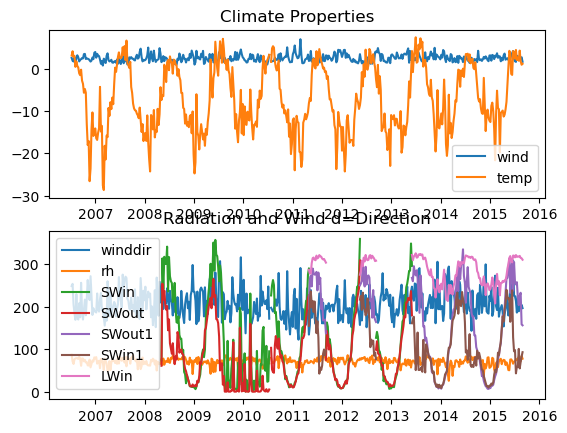

In [15]:
fig,[ax1,ax2] = plt.subplots(2,1)
climate_vars = ['temp','tp','wind','dtemp']
df_plot = df.resample('W').mean()
for var in df.columns:
    if not np.all(np.isnan(df[var])):
        if var in climate_vars:
            ax1.plot(df_plot.index,df_plot[var],label=var)
        elif var != 'LWout':
            ax2.plot(df_plot.index,df_plot[var],label=var)
ax1.set_title('Climate Properties')
ax2.set_title('Radiation and Wind d=Direction')
ax1.legend()
ax2.legend()
plt.show()

Multiple data files

In [48]:
# def merge_files(fns):
fns = data_fns[0:2]
df = pd.read_csv(AWS_fp+fns[0],index_col=time_vn)
timestep_original = pd.to_datetime(df.index[1]) - pd.to_datetime(df.index[0])
for fn in fns[1:]:
    df_load = pd.read_csv(AWS_fp+fn,encoding='ISO-8859-1')
    timestep_load = pd.to_datetime(df_load.index[1]) - pd.to_datetime(df_load.index[0])
    if timestep_load < timestep_original:
        print(timestep_load.seconds)

/tmp/ipykernel_14775/361441679.py:6: DtypeWarning: Columns (11,13,14,15,16) have mixed types. Specify dtype option on import or set low_memory=False.
  df_load = pd.read_csv(AWS_fp+fn,encoding='ISO-8859-1')


0


In [1]:
def basic_stats(fn,header,droprows):
    df = pd.read_csv(AWS_fp+fn,header=header,encoding = 'ISO-8859-1')
    df = df.drop(droprows,axis=0)
    df = df.set_index(time_vn)
    for column in df.columns:
        print(column,'Nonzero count:',df[column].count(),'          ',df[column].mean())

In [33]:
basic_stats(data2_fn,1,[0,1])

/tmp/ipykernel_2729/916621188.py:2: DtypeWarning: Columns (1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(AWS_fp+fn,header=header,encoding = 'ISO-8859-1')


RECORD Nonzero count: 956668
WS_ms_S_WVT Nonzero count: 956668
WindDir_D1_WVT Nonzero count: 956668
WindDir_SD1_WVT Nonzero count: 956668
WS_ms_Max Nonzero count: 956668
AirTC Nonzero count: 956668
NR_Wm2_Avg Nonzero count: 956668
CNR_Wm2_Avg Nonzero count: 191532
RH Nonzero count: 956668
SWin_Wm2_Avg Nonzero count: 457951
SWout_Wm2_Avg Nonzero count: 457951
cnr4_T_C_Avg Nonzero count: 307187
short_up_Avg Nonzero count: 307187
short_dn_Avg Nonzero count: 307187
long_up_corr_Avg Nonzero count: 307187
long_dn_corr_Avg Nonzero count: 307187


In [8]:
import pandas as pd
df = pd.read_csv('/home/claire/research/climate_data/AWS/Preprocessed/saintsorlin/saintsorlin_hourly.csv',index_col=0)
print(df.index.to_numpy()[-1])

2021-12-31 23:00:00
